# Pinecone(파인콘)
- https://www.pinecone.io/
- Pinecone은 AI 및 머신러닝 애플리케이션을 지원하기 위해 설계된 클라우드 기반 벡터 데이터베이스다. 
- 고차원 벡터 임베딩을 효율적으로 저장하고 검색할 수 있는 플랫폼을 제공하며, 사용자가 의미 기반 검색, 추천 시스템, 이미지 유사성 검색 등 다양한 기능을 애플리케이션에 손쉽게 통합할 수 있도록 돕는다.
-  현재 Milvus, Weaviate, Chroma 등 다른 벡터 데이터베이스들과 비교했을 때 가장 선호되는 솔루션이다.
- Vector Database 순위: https://db-engines.com/en/ranking/vector+dbms

## 장점
- **유사성 검색 지원**
  -  Pinecone은 데이터 간의 유사성을 기반으로 가장 가까운 결과를 제공하는 유사성 검색 기능을 지원한다. 
- **초저 지연 속도** 
  - 초당 수십억 개의 항목을 검색할 수 있으며, 지연 속도는 50ms 미만으로 매우 빠르다. 
- **실시간 데이터 처리**
  - 새로운 데이터의 즉각적인 추가 및 인덱싱 지원.
  - 다운타임(downtime-시스템을 이용할 수 없는 시간) 없이 최신 데이터에 지속적으로 접근 가능.
- **확장성** 
  - AI 응용 프로그램이 확장됨에 따라 데이터 용량이 커질 경우에도 안정적인 성능을 제공한다. 
- **클라우드 기반 완전 관리형 인프라 제공** 
  - Pinecone은 클라우드에서 벡터 데이터를 저장하고 관리하기 때문에 개발자가 직접 인프라를 관리할 필요가 없다. 
  - 데이터 백업, 복구, 보안, 스케일링, 장애 복구등과 같은 인프라 운영을 pinecone이 담당하므로 개발자는 데이터에 집중할 수 있다.
- **개발자 친화성**
  -  API와 Python 클라이언트를 제공하여 쉽게 시작하고 사용할 수 있으며, 다양한 프로그래밍 언어와 프레임워크와의 통합이 원활하다. 


## package 설치
  - `pip install -qU pinecone-client`
  - `pip install -qU langchain-pinecone`

## Pinecone API Key 생성
- **로그인 후 API Key를 생성하고 복사한다.**
  
![pinecone_apikey.png](figures/pinecone_apikey.png)
- **복사한 API Key를 환경변수에 등록한다.**
    - 변수명: `PINECONE_API_KEY` 
    - `.env`에 등록한 뒤 `dotenv` 모듈을 이용해 Loading.

In [ ]:
# %pip install -qU pandas matplotlib tqdm ipywidgets
# %pip install -qU pinecone-client langchain-pinecone

## Index 생성
- **Index**는 RDMBS에서의 Database 역할을 한다.
- Main -> Database -> Indexes -> Create Index

![pinecone_index_create.png](figures/pinecone_index_create.png)

- **Index 이름, Dimensions, Metric** 을 넣고 생성한다. (Create Index)
    - 나머지 항목은 유료 Plan에서만 변경할 수있다.
    - **Dimensions**
        -  Vector 차원 수
        -  아래 Pretrained Embedding 모델을 선택하면 그것에 맞춰 dimension을 잡아준다. 
    - **Metric**: 유사도 확인시 사용할 방법

![pinecone_index_create2](figures/pinecone_index_create2.png)

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
# print(PINECONE_API_KEY)

In [4]:
INDEX_NAME = 'embedding3'
NAMESPACE = 'embedding3-ns-1'
# index - Database
# namespace - Table

# Pinecone API 이용해 연동

## Pinecone Client 초기화(생성)

In [5]:
from pinecone import Pinecone

pc = Pinecone(api_key=PINECONE_API_KEY) # Pinecone 서비스에 연결.

In [6]:
# index와 연결
index = pc.Index(INDEX_NAME) 

In [7]:
# 연결된 index의 정보를 확인
index_info = index.describe_index_stats()
print(index_info)

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}


## Record Upsert
- **Upsert**: index에 vector data를 저장.
- `Index.upsert()`: Index에 vector data를 저장 및 수정.
  - **vectors**: upsert할 Record들을 List에 담아서 전달한다.
    - 개별 데이터는 dict 형태로 전달한다. **key는 id, values, metadata**로 구성된다.
      - **"id"**: Record의 고유 ID. 같은 id로 upsert하면 기존 데이터를 수정한다.
        - 문자열(string) 타입 사용.
        - 각 벡터의 ID는 인덱스 내에서 고유해야 한다.
        - 최대 길이는 **512바이트** 이다.
        - 사용 가능한 문자는 영숫자, `-`, `_`, `#`, `:` 이다.
        - 대소문자를 구분한다.
      - **"values"**: Record의 의미를 나타내는 Embedding Vector. Record 조회할 때 유사도 계산에 사용된다.
      - **"metadata"**: Record의 추가 정보. 보통 실제 조회결과로 사용할 데이터를 key-value 쌍의 dictionary로 저장한다. 조회할 때 조회조건으로도 사용할 수 있다. (optional)
        - value에는 **문자열, 정수, 실수, boolean, 문자열리스트**가 가능하다. value에 null은 올 수 없다. 이 경우 해당 key를 제거한다.
  - **namespace**: Record들을 저장할 Index 내의 namespace 이름

> - **Namespace**
>     - Index 내의 데이터들을 분리하기 위한 이름 공간. Index 내에 여러 개의 namespace를 생성할 수 있다.
>    - namespace를 사용하면 Index 내에 여러 개의 데이터 집합을 저장하고, 각 데이터 집합을 분리하여 관리할 수 있다.
>    - 관계형 데이터베이스 기준에서 **Index는 Database, namespace는 Table**로 볼 수 있다. 

In [ ]:
# list[dict]  개별 데이터를 dictionary로 정의.
upsert_data = [
    {
        "id":"vec1",
        "values":[1.0, 1.5, 2.0], # embedding 모델이 변환한 embedding vector
        "metadata":{"genre":"drama", "title":"별에서 온 그대"}, # 조회결과로 사용할 값 + 이 데이터에 대한 정보.
    }, 
    {
        "id":"vec2",
        "values":[2.0, 1.0, 0.5],
        "metadata":{"genre":"action", "title":"트랜스포터"}
    },
    {
        "id":"vec3",
        "values":[0.1, 0.3, 0.7],
        "metadata":{"genre":"drama", "title":"사랑의 불시착"}
    },
    {
        "id":"vec4",
        "values":[1.0, 2.7, 3.6],
        "metadata":{"genre":"action", "title":"킹덤"}
    },
    {
        "id":"vec5",
        "values":[0.2, 0.6, 0.5],
        "metadata": {"genre":"drama", "title":"눈물의 여왕"}
    },
    {
        "id":"vec6",
        "values":[0.3, 1.1, 3.3],
        "metadata":{"genre":"comedy", "title":"마스크"}
    }
]

# upsert()
index.upsert(
    vectors=upsert_data, # upsert(insert) 할 데이터셋
    namespace=NAMESPACE  # upsert할 namespace
    # namespace="embedding3-ns-2"
)

{'upserted_count': 6}

In [10]:
print(index.describe_index_stats()) # index 정보 확인

{'dimension': 3,
 'index_fullness': 0.0,
 'namespaces': {'embedding3-ns-1': {'vector_count': 6},
                'embedding3-ns-2': {'vector_count': 6}},
 'total_vector_count': 12}


### 파인콘 Home에서 확인
- Main -> Database -> Indexes 에서 **index**를 선택한다.
- Upsert된 데이터를 확인할 수있다.
- 직접 값을 넣어 저장된 데이터 중 유사도 높은 K개 조회를 할 수있다.
![pinecone_index_search.png](figures/pinecone_index_search.png)

## Query(조회하기)
- `Index.list(namespace)`
    -  namespace에 있는 모든 record 의 id들 조회
-  `Index.fetch(ids, namespace)`
    -  namespace의 지정한 id의 recored들을 조회
    -  ids: list - 조회하려는 id들을 리스트로 묶어 전달
- `Index.query()`
    - query vector(조회하려는 vector)와 유사도가 높은 record들 조회 
    - namespace: 대상 namespace
    - vector: query vector
    - top_k: query vector와 유사한 것 몇개를 조회할 지 설정
    - include_values: value 조회결과에 포함 여부
    - include_metadata: metadata 조회결과에 포함 여부
    - filter: Meta data 값을 이용해 추가 조회조건을 지정한다.
- filter에서 사용하는 연산자.
    - `$eq`: 지정된 값과 동일한 메타데이터 값을 가진 벡터를 찾습니다.
    - `$ne`: 지정된 값과 다른 메타데이터 값을 가진 벡터를 찾습니다.
    - `$gt`: 지정된 값보다 큰 메타데이터 값을 가진 벡터를 찾습니다.
    - `$gte`: 지정된 값보다 크거나 같은 메타데이터 값을 가진 벡터를 찾습니다.
    - `$lt`: 지정된 값보다 작은 메타데이터 값을 가진 벡터를 찾습니다.
    - `$lte`: 지정된 값보다 작거나 같은 메타데이터 값을 가진 벡터를 찾습니다.
    - `$in`: 지정된 배열 내의 값 중 하나를 가진 메타데이터 값을 가진 벡터를 찾습니다.
    - `$nin`: 지정된 배열 내의 값과 다른 메타데이터 값을 가진 벡터를 찾습니다.
    - `$exists`: 특정 메타데이터 필드가 존재하는 벡터를 찾습니다. 

In [20]:
query_vec = [0.1, 0.3, 0.7]
res = index.query(
    namespace=NAMESPACE,
    vector=query_vec,   # 대상 query vector
    top_k=3, # 몇개를 조회할 지정.
    include_values=True,  # values(embedding vector) 를 결과에 포함할 지 여부
    include_metadata=True # metadata를 결과에 포함할 지 여부.
)

print(res)

{'matches': [{'id': 'vec3',
              'metadata': {'genre': 'drama', 'title': '사랑의 불시착'},
              'score': 0.997341454,
              'values': [0.1, 0.3, 0.7]},
             {'id': 'vec6',
              'metadata': {'genre': 'comedy', 'title': '마스크'},
              'score': 0.994015276,
              'values': [0.3, 1.1, 3.3]},
             {'id': 'vec4',
              'metadata': {'genre': 'action', 'title': '킹덤'},
              'score': 0.965858519,
              'values': [1.0, 2.7, 3.6]}],
 'namespace': 'embedding3-ns-1',
 'usage': {'read_units': 6}}


In [ ]:
res = index.query(
    namespace=NAMESPACE,
    vector=query_vec,   # 대상 query vector
    top_k=3, # 몇개를 조회할 지정.
    # include_values=True,  # values(embedding vector) 를 결과에 포함할 지 여부
    include_metadata=True, # metadata를 결과에 포함할 지 여부.
    filter = {  # 추가 검색 조건 -> metadata의 정보를 이용해 지정.
        "genre":{"$eq":"action"} # metadata의 키:{연산자:값} -> genre:action 인 데이터들만 유사도를 계산.
        # , "genre":{"$exists":True} # genre key가 있는 데이터들.
        # , "year":{"$gt":2020}  # year가 2020 보다 큰 데이터들.

    }
)
# filter가 없으면 전체 record들을 대상으로 검색.
# filter가 있으면 그 조건이 True인 record들을 대상으로 검색.
print(res)

{'matches': [{'id': 'vec4',
              'metadata': {'genre': 'action', 'title': '킹덤'},
              'score': 0.965858519,
              'values': []},
             {'id': 'vec2',
              'metadata': {'genre': 'action', 'title': '트랜스포터'},
              'score': 0.483622849,
              'values': []}],
 'namespace': 'embedding3-ns-1',
 'usage': {'read_units': 6}}


In [25]:
for record in res['matches']:
    print(record['metadata']["title"])

킹덤
트랜스포터


In [ ]:
# namespace에 전체 record의 id들을 조회
list(index.list(namespace=NAMESPACE)) # index.list() -> generator

[['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']]

In [28]:
for ids in index.list(namespace=NAMESPACE):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [29]:
# id로 조회
res = index.fetch(["vec1", "vec4"], namespace=NAMESPACE)
print(res)

{'namespace': 'embedding3-ns-1',
 'usage': {'read_units': 1},
 'vectors': {'vec1': {'id': 'vec1',
                      'metadata': {'genre': 'drama', 'title': '별에서 온 그대'},
                      'values': [1.0, 1.5, 2.0]},
             'vec4': {'id': 'vec4',
                      'metadata': {'genre': 'action', 'title': '킹덤'},
                      'values': [1.0, 2.7, 3.6]}}}


In [31]:
# vector들을 시각화
res = index.fetch(
    ['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6'],
    namespace=NAMESPACE
)
res

{'namespace': 'embedding3-ns-1',
 'usage': {'read_units': 1},
 'vectors': {'vec1': {'id': 'vec1',
                      'metadata': {'genre': 'drama', 'title': '별에서 온 그대'},
                      'values': [1.0, 1.5, 2.0]},
             'vec2': {'id': 'vec2',
                      'metadata': {'genre': 'action', 'title': '트랜스포터'},
                      'values': [2.0, 1.0, 0.5]},
             'vec3': {'id': 'vec3',
                      'metadata': {'genre': 'drama', 'title': '사랑의 불시착'},
                      'values': [0.1, 0.3, 0.7]},
             'vec4': {'id': 'vec4',
                      'metadata': {'genre': 'action', 'title': '킹덤'},
                      'values': [1.0, 2.7, 3.6]},
             'vec5': {'id': 'vec5',
                      'metadata': {'genre': 'drama', 'title': '눈물의 여왕'},
                      'values': [0.2, 0.6, 0.5]},
             'vec6': {'id': 'vec6',
                      'metadata': {'genre': 'comedy', 'title': '마스크'},
                      'values': [0.3

In [ ]:
# values(embedding vector) 만 추출
res['vectors']  # dict[str:id, dict:정보]
res['vectors'].values() # dict의 value들만 조회

embedding_vectors = [value['values'] for value in res['vectors'].values()]
ids = [value['id'] for value in res['vectors'].values()]

# query_vector를 추가
embedding_vectors.append(query_vec)
ids.append("query_vector")

embedding_vectors, ids

([[1.0, 1.5, 2.0],
  [0.3, 1.1, 3.3],
  [0.2, 0.6, 0.5],
  [1.0, 2.7, 3.6],
  [2.0, 1.0, 0.5],
  [0.1, 0.3, 0.7],
  [0.1, 0.3, 0.7]],
 ['vec1', 'vec6', 'vec5', 'vec4', 'vec2', 'vec3', 'query_vector'])

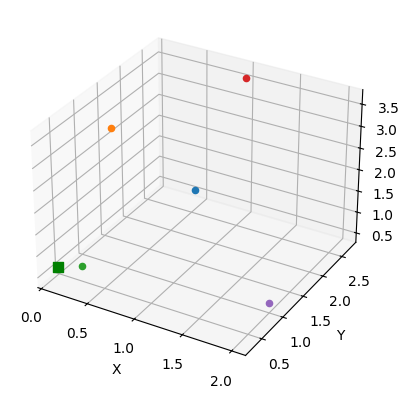

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  # 3차원(x, y, z) 그래프를 그릴 axes 반환
for idx, id in enumerate(ids):
    if id == "query_vector": # 다른 모양의 점을 찍기.
        ax.scatter(
            embedding_vectors[idx][0], # x축 좌표
            embedding_vectors[idx][1], # y축 좌표
            embedding_vectors[idx][2], # z축 좌표
            color="green",
            s=50,  # 점 크기
            marker="s" #점모양
        )
    else:
        ax.scatter(
            embedding_vectors[idx][0], # x축 좌표
            embedding_vectors[idx][1], # y축 좌표
            embedding_vectors[idx][2], # z축 좌표
        )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.show()

## ServerLess Index 생성
- 코드로 Index 생성

### Index들 조회
- `Pinecone.list_indexes()`

### index 삭제
- `Pinecone.delete_index("index 이름")`

### Index 생성
- `Pinecone.create_index()`
  - **name**: Index 이름
  - **dimension**: Embedding vector 차원 수
  - **metric**: 유사도 계산 방법
  - **spec**: ServerlessSpec - 추가설정

In [ ]:
data = [
    {"id": "rec01", "text": "사과는 건강에 좋은 과일로 아침에 먹기 좋아요."},
    {"id": "rec02", "text": "애플은 전 세계적으로 인기 있는 기술 회사입니다."},
    {"id": "rec03", "text": "가을에 수확한 사과는 달콤하고 영향소가 풍부합니다."},
    {"id": "rec04", "text": "애플의 아이폰은 많은 사람들이 선호하는 스마트폰이에요."},
    {"id": "rec05", "text": "사과를 갈아 만든 주스는 아침에 마시기 좋습니다."},
    {"id": "rec06", "text": "애플은 혁신적인 제품으로 기술 산업을 이끌고 있습니다."},
    {"id": "rec07", "text": "빨간 사과와 초록 사과 중 어떤 것을 좋아하세요?"},
    {"id": "rec08", "text": "애플의 맥북은 디자인과 성능 면에서 뛰어난 평가를 받습니다."},
    {"id": "rec09", "text": "사과는 다이어트와 건강 관리에 효과적인 과일이에요."},
    {"id": "rec10", "text": "애플은 환경을 고려한 지속 가능한 제품을 생산하려고 합니다."},
    {"id": "rec11", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다."},
    {"id": "rec12", "text": "애플은 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다."}
]

### Embedding Vector로 변환
- `Pinecone.inference.embed()`  
  - 텍스트 데이터를 임베딩 벡터로 변환
  - **`inputs`**:  
    - 임베딩할 텍스트 데이터를 지정.  
-  **`parameters`**:  
   - 추가적인 파라미터를 dictionary에 넣어 설정.
   - **`input_type`**:  
       - 입력 데이터 유형 지정.  
         - `"passage"`: 문단 또는 긴 텍스트임을 알려준다..  
         - `"query"`: 검색 쿼리 임을 알려준다.  
       - 모델이 입력 데이터를 어떻게 처리할 지 방식 결정하는데 사용된다.

     - **`truncate`**:  
       - 입력 데이터가 모델의 최대 길이(embedding 모델이 학습할 때 사용한 문장의 최대길이)를 초과할 경우 처리 방법 지정.
       - **옵션**:  
         - `"NONE"`: 입력 텍스트를 자르지 않음.  
         - `"START"`: 텍스트 시작 부분 기준으로 잘림. (앞을 자름.) 
         - `"END"`: 텍스트 끝 부분 기준으로 잘림. (뒤를 자름)
       - **특징**:  
         - 설정된 방향에서 자동으로 자름.



#### Record Upsert

##### Upsert 할 Record set 만들기
- 아래 구조로 만든다
```
{"id": id, 
 "values": 변환된 embedding vector,
 "metadata": {"text": 원문텍스트}}
```

### Query

#### Query를 Vector로 변환 

#### Vector DB에서 query와 유사한 Record 조회

# Langchain 을 이용해 Pinecone 연동

## pipnecone 에 Index 만들기
- 주의: embedding vector 차원을 사용하는 embedding model의 차원에 맞춰야 한다.
- openai embedding 모델 output 차원 확인
  - https://platform.openai.com/docs/models#embeddings 

## Dataset 만들기

In [ ]:
dataset = [
    {"id": "rec01", "text": "사과는 건강에 좋은 과일로 아침에 먹기 좋아요.", "metadata": {"category": "fruit"}},
    {"id": "rec02", "text": "애플은 전 세계적으로 인기 있는 기술 회사입니다.", "metadata": {"category": "it"}},
    {"id": "rec03", "text": "가을에 수확한 사과는 달콤하고 영향소가 풍부합니다.", "metadata": {"category": "fruit"}},
    {"id": "rec04", "text": "애플의 아이폰은 많은 사람들이 선호하는 스마트폰이에요.", "metadata": {"category": "it"}},
    {"id": "rec05", "text": "사과를 갈아 만든 주스는 아침에 마시기 좋습니다.", "metadata": {"category": "fruit"}},
    {"id": "rec06", "text": "애플은 혁신적인 제품으로 기술 산업을 이끌고 있습니다.", "metadata": {"category": "it"}},
    {"id": "rec07", "text": "빨간 사과와 초록 사과 중 어떤 것을 좋아하세요?", "metadata": {"category": "fruit"}},
    {"id": "rec08", "text": "애플의 맥북은 디자인과 성능 면에서 뛰어난 평가를 받습니다.", "metadata": {"category": "it"}},
    {"id": "rec09", "text": "사과는 다이어트와 건강 관리에 효과적인 과일이에요.", "metadata": {"category": "fruit"}},
    {"id": "rec10", "text": "애플은 환경을 고려한 지속 가능한 제품을 생산하려고 합니다.", "metadata": {"category": "it"}},
    {"id": "rec11", "text": "하루에 사과 하나면 의사를 멀리할 수 있다는 속담이 있습니다.", "metadata": {"category": "fruit"}},
    {"id": "rec12", "text": "애플은 1976년 4월 1일 스티브 잡스, 스티브 워즈니악, 로널드 웨인에 의해 파트너십으로 설립되었습니다.", "metadata": {"category": "it"}}
]

## Vector Store 생성 및 초기화

- PineconeVectorStore.from_documents()
  - VectorStore를 초기화(생성)하고 문서를 추가한다. 

## Vector Store 연결
- 문서 추가 없이 연결만 한다.
- PineconeVectorStore(index="Index이름", embedding=embedding_model)

## 추가, 수정
- `vectorStore.add_documents(documents:list, ids:list)`
  - documents: 추가할 문서들
  - ids: 추가, 수정할 문서들의 id. 없으면 추가, 있으면 수정한다.

## 삭제
- `vectorStore.delete(ids:str)`
  - ids: 삭제할 문서들의 id

## Query
- 유사도 검색을 통해 유사도가 높은 record를 조회
- `vectorStore.similarity_search(query: str, k: int, filter: dict)`
  - query: 검색할 문서
  - k: 유사도가 높은 record의 개수
  - filter: metadata를 이용한 추가 조회 조건 설정
  - namespace: index의 namespace
- `vectorStore.similarity_search_with_score()`
  - similarity_search()와 동일한 기능을 하지만, 유사도 점수를 함께 반환한다.